# Accessible Transit: Improving Equity in Ithaca's Public Transportation System

## 1. Introduction, Problem Statement, and Background

Public transportation plays a significant role in the mobility of people in urban areas. A well-designed public transportation system helps in reducing traffic congestion, air pollution, and promotes equitable access to opportunities and services. However, the spatial distribution of infrastructure can be biased, which may leave several geographical locations underserved. To design a more cohesive system and eliminate issues of inaccessibility, an inclusive data representation is crucial. This project aims to explore the importance of data representation while designing transit systems and predict new bus stops for the public transportation of Ithaca, New York.

The existing spatial distribution of infrastructure for public transportation in Ithaca, New York, may not be serving all communities equally. The underserved communities may face difficulties accessing opportunities and services due to a lack of transportation options. Additionally, the current infrastructure may not be optimized for the changing needs of the growing population of Ithaca. To address these issues, a data-driven approach is necessary to represent the needs of different communities and design a more inclusive public transportation system.

Ithaca is a city located in the Finger Lakes region of New York State, with a population of approximately 31,000 people. The city has a significant student population due to the presence of Cornell University and Ithaca College. The existing public transportation system in Ithaca includes buses operated by TCAT (Tompkins Consolidated Area Transit) and offers services to both the city and surrounding areas. However, the spatial distribution of bus stops may not be serving all communities equally, leading to issues of inaccessibility and limited mobility options for some residents. This project aims to use data science techniques to analyze the spatial distribution of bus stops and predict new bus stops to improve the existing public transportation system in Ithaca.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing relevant libraries
# Reading data
import pandas as pd
import geopandas as gpd

# Importing libraries for network analysis
import networkx as nx
import numpy as np
import osmnx as ox

# Importing libraries for spatial weights
from pysal.lib import weights
from esda.moran import Moran

# Mapping and plotting
import matplotlib.pyplot as plt
import contextily as ctx
# configure OSMnx
ox.settings.log_console = True

## 2. Methodology


1. **Data Collection**: This study utilized two primary sources of data: bus stops data for Ithaca's transit system and census data at the block group level obtained from the Integrated Public Use Microdata Series (IPUMS) project. The bus stops data was acquired using the OSmnx library in Python, which offers an interface to the OpenStreetMap database. On the other hand, the census data encompassed variables such as total population, population density, percentage of minority residents, median household income, and the percentage of the population that travels.

2. **Data Preprocessing**: Prior to conducting the analysis, the collected data underwent a series of cleaning and preprocessing steps. First, the distance of each block group to significant locations in Ithaca, such as downtown, Cornell University, Ithaca College, and Ithaca Mall, was calculated. Subsequently, a spatial join was performed between the bus stops and block group census data to establish the association between bus stops and their corresponding block groups. The number of bus stops in each block group was then computed. Finally, a dataset was generated, consisting of the independent variables (total population, population density, percentage of minority residents, median household income, and the percentage of the population that travels) and the dependent variable (the number of bus stops in each block group).

3. **Modeling**: Two regression models, namely ordinary least squares (OLS) and spatial lag regression, were employed to predict the number of bus stops in each block group. The OLS model represents a standard linear regression approach that estimates the relationship between the dependent variable and the independent variables. In contrast, the spatial lag model accounts for the spatial autocorrelation of the dependent variable, recognizing that the number of bus stops in a block group is influenced by the number of bus stops in neighboring block groups. The spatial lag model estimates the relationship between the dependent variable and the independent variables, along with the spatial lag of the dependent variable.

4. **Interpretation of Results**: The interpretation of the study's results involved examining the coefficients of the independent variables in the regression models. These coefficients offer insights into the direction and strength of the relationship between each independent variable and the dependent variable. By analyzing the coefficients, one can discern the impact that variables such as total population, population density, percentage of minority residents, median household income, and the percentage of the population that travels have on the number of bus stops in each block group. Finally, the performance of the OLS and spatial lag models was compared using metrics such as R-squared to assess their predictive capabilities.

## 3. Data Collection and Data Preprocessing


#### 3.1. Ithaca Bus Stops

Collecting data on bus stops is a critical part of designing a public transportation system. Bus stop data includes location information and other characteristics that help planners and analysts to identify service gaps, optimize bus routes, and improve service quality. One way to collect bus stop data is through the use of OpenStreetMap (OSM), a collaborative, open-source mapping platform.

The data collected from OSMnx includes the location of each bus stop, along with additional attributes such as name, ID, and other relevant information. This data can be analyzed to identify patterns in the distribution of bus stops, assess the accessibility of public transportation, and inform the development of new bus routes or the modification of existing ones.

In [3]:
# Download/model a street network for Ithaca then visualize it
ithaca_address = 'Ithaca, New York, USA'
ithaca_streets = ox.graph_from_place(ithaca_address, network_type='drive')

# Bus stops in the Ithaca
tags = {'highway': 'bus_stop'}
ithaca_busstops = ox.geometries_from_place(ithaca_address, tags)

# Dropping unnecessary columns
ithaca_busstops = ithaca_busstops.drop(columns=['brand:wikidata', 'brand', 'amenity', 'name:en', 'tactile_paving', 
                                                'bin', 'lit', 'wheelchair', 'bench', 'bus', 'departures_board', 'local_ref', 'ref', 'covered', 'description', 'shelter'])

#### 3.2. Ithaca Bus Stops Buffer

By creating a walking buffer around each bus stop buffer, the areas that are accessible within a given walking distance of each bus stop can be estimated. This information can be used to analyze the extent to which the existing public transit system is serving different parts of the community and to identify areas that may be underserved.

In [4]:
# Let's convert crs to epsg 4326
ithaca_busstops = ithaca_busstops.to_crs(epsg=3857)

# First, let's make geometries
buffer_geom = ithaca_busstops['geometry'].buffer(800)

# Second, I already know the CRS
# This the same as the CRS of Ithaca Busstop data 
buffer_crs = ithaca_busstops.crs 

# Third, let's grab the data we want
buffer_data = ithaca_busstops[['name']]  

# Now, let's put it all together using the GeoDataFrame constructor
ithaca_busstops_buffer = gpd.GeoDataFrame(buffer_data, crs=buffer_crs, geometry=buffer_geom)

# Changing CRS back to epsg=4326
ithaca_busstops_buffer = ithaca_busstops_buffer.to_crs(epsg=4326)
ithaca_busstops = ithaca_busstops.to_crs(epsg=4326)

<AxesSubplot: title={'center': 'Ithaca Bus Stops'}>

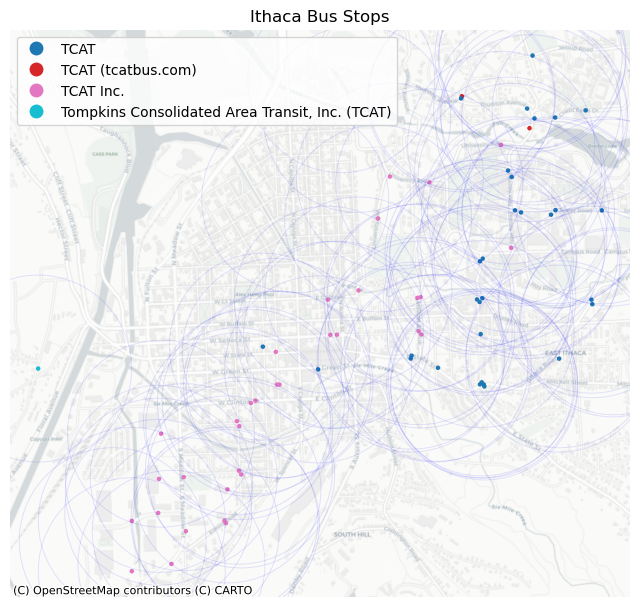

In [5]:
# Visualzing the buffers
fig1, ax1 = plt.subplots(figsize=(8, 8))

# Adding title
plt.title('Ithaca Bus Stops')
ax1.set_axis_off()

# Plotting bus stops and adding basemap
ithaca_busstops.plot(ax=ax1, markersize=5, column = 'operator', legend = True)
ctx.add_basemap(ax=ax1, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

# Plotting buffers
ithaca_busstops_buffer.plot(ax=ax1, facecolor="none", alpha=0.1, edgecolor="blue", lw=.7)

### 3.2. Census Data for Tompkins County

Census data for Tompkins County at the block group level provides valuable information about the demographic and socioeconomic characteristics of the population living in each block group. The detailed information on variables such as total population, percentage of minority, median household income, etc., has been extracted using IPUMS.

#### 3.2.1. Extracting block groups data for Tompkins County

In [6]:
# Extracting block_grps data for NY State
block_grps = gpd.read_file('nhgis0002_shape/nhgis0002_shape/nhgis0002_shapefile_tl2021_us_blck_grp_2021.zip')

# Dropping all rows except Tompkins County
block_grps = block_grps[block_grps['COUNTYFP']=='109']

# Finding the centroid of the geometries and adding a new column for centroids
block_grps['centroids'] = block_grps['geometry'].centroid

# Changing the crs to epsg 4326
block_grps = block_grps.to_crs(epsg = 4326)

#### 3.2.2. Extracting census data for Tompkins County

In [7]:
# Extracting Census data
raw_acs_data = pd.read_csv('nhgis0002_csv/nhgis0002_csv/nhgis0002_ds254_20215_blck_grp.csv',encoding='latin-1')

# Listing the columns that will be needed 
cols_need = ['GISJOIN', 'AOQIE001','AON5E007','AON5E006', 'AON5E005','AON5E004','AON5E003','AON5E001', 'AOOTE011', 'AOOTE001']

# Creating a new dataframe with the necessary columns
acs_data_n = raw_acs_data[cols_need]

# Renaming columns in acs_data_n for convenience
acs_data_n = acs_data_n.rename(columns= {'AOQIE001': 'median_hh_inc',
                                        'AON5E007': 'pop_some_race',
                                        'AON5E006': 'pop_hawaiian',
                                        'AON5E005': 'pop_asian',
                                        'AON5E004': 'pop_am_indian',
                                        'AON5E003': 'pop_black',
                                        'AON5E001': 'total_pop',
                                        'AOOTE011': 'pop_takes_bus',
                                        'AOOTE001': 'pop_travels'
                                        })

In [8]:
# Calculating %minority and adding perc_minority column to acs_data_n
acs_data_n['perc_minority'] = (acs_data_n['pop_black'] + acs_data_n['pop_some_race'] + acs_data_n['pop_hawaiian'] + acs_data_n['pop_asian'] + acs_data_n['pop_am_indian'])/acs_data_n['total_pop']

# Calculating % of people that take bus in each block groups
acs_data_n['perc_takes_bus'] = acs_data_n['pop_takes_bus']/acs_data_n['pop_travels']

#### 3.2.3. Census data at block group level

In [9]:
# Joining the acs_data with block_grps data
blockgrps_acs = block_grps.merge(acs_data_n, on='GISJOIN')

# Calculating the population density and adding it as a new column pop_density
blockgrps_acs['pop_density'] = blockgrps_acs['total_pop']/blockgrps_acs['ALAND']

#### Creating a visual summary of blockgrps_acs dataset

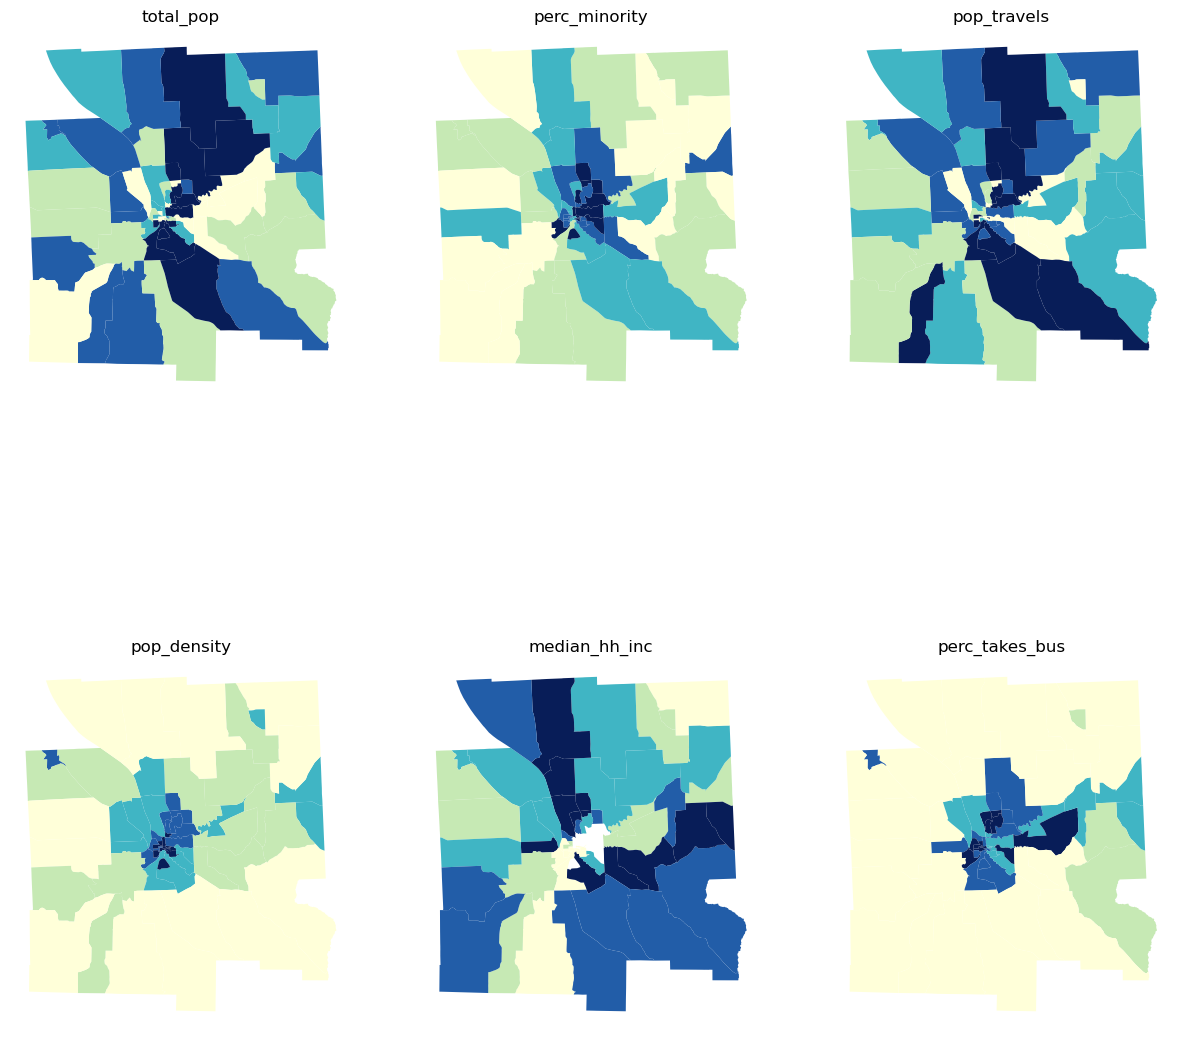

In [40]:
# Picking the variables that I want to visualize
plot_variables = ["total_pop", "perc_minority", "pop_travels", "pop_density", "median_hh_inc", "perc_takes_bus"]

# Building a visual summary of the data
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(plot_variables):
    ax = axs[i]
    # Plot the map
    blockgrps_acs.plot(column=col, ax=ax, scheme="Quantiles", linewidth=0.5, cmap="YlGnBu")
    ax.set_axis_off()
    ax.set_title(col)
plt.show()

#### Interpreting the datasets

1. The **total population** is highest in the blocks colored in darker blue, indicating that these areas have the largest overall population. However, it is worth noting that the central block groups, although not as large in total population, have a higher population density.

2. The **percentage of minority residents** is mostly concentrated in the central blocks, indicating that these areas have a higher proportion of residents who identify as racial or ethnic minorities. However, it is important to note that the majority of Tompkins County is not classified as minority.

3. **Median household income** is lowest in the central blocks, depicted in off-white. Other blocks have comparatively higher median household incomes, depicted in the darker blue color. This suggests that the central blocks may have a lower socioeconomic status than other areas of the county.

4. The **population that travels** is distributed similarly to the overall population distribution in Tompkins County. This suggests that transportation needs are generally proportional to the population size of each area.

5. The **percentage of residents who use public transit** is also concentrated in the central blocks, indicating a higher reliance on public transportation in these areas. This information is important for identifying areas where public transportation is particularly important and where improvements to public transportation infrastructure may be most beneficial.


<AxesSubplot: title={'center': "TCAT's Service Catchment Area"}>

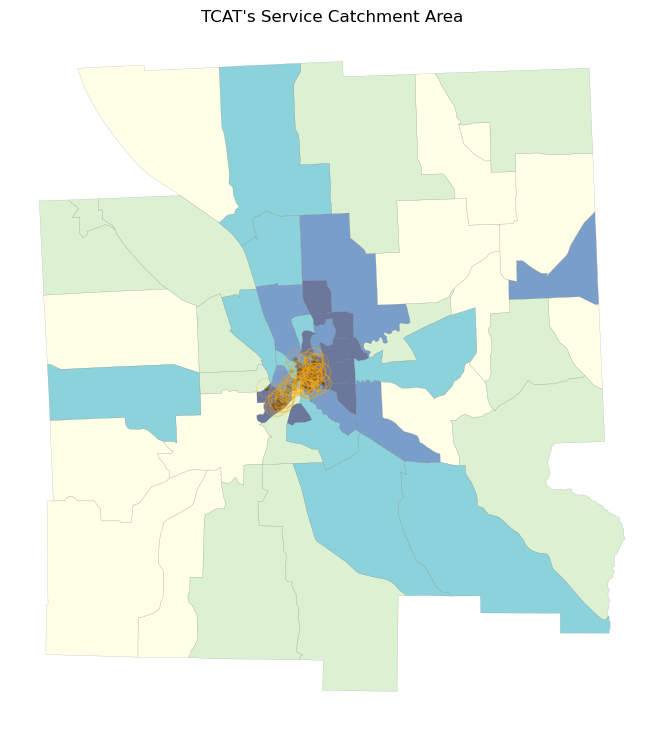

In [11]:
# Visualzing the Service Catchment Area
fig1, ax1 = plt.subplots(figsize=(9, 9))

# Adding title
plt.title("TCAT's Service Catchment Area")
ax1.set_axis_off()

# Plotting bus stops and adding basemap
ithaca_busstops.plot(ax=ax1, markersize=5, color = 'orange')

# Plotting block groups
blockgrps_acs.plot(column= 'perc_minority', ax=ax1, scheme="Quantiles", linewidth=0.5, cmap="YlGnBu", alpha=0.6, edgecolor="grey", lw=.2)

# Plotting buffers
ithaca_busstops_buffer.plot(ax=ax1, facecolor="none", alpha=0.3, edgecolor="orange", lw=.7)

The map displays the **locations of bus stops overlaid on a map of block groups colored by the percentage minority**. The **catchment area** of the bus stops appears to be **concentrated in a few central blocks**, while other blocks appear to be devoid of bus stops. This suggests that there may be **areas of the county that are underserved by public transportation**, which highlights the importance of this study in identifying areas with unique transportation needs and developing strategies to create a more equitable and inclusive transportation system for all residents of Tompkins County.

### 3.4. Adding Spatial Variables

Spatial variables are variables that capture the spatial context of each observation, such as its distance to other locations or its proximity to other geographic features.
Including spatial variables in a spatial regression model can help account for the spatial dependence in the data and improve the accuracy of the model's predictions. Spatial variables can provide additional information about the location of each observation and how it relates to other observations in the dataset.

1. **Distance to Downtown**: This variable measures the distance between each block group and downtown Ithaca, which is the central business district and a major employment center in the area. This variable could be a predictor of public transportation demand, as residents who work or shop downtown may be more likely to use public transportation.

2. **Distance to Cornell**: This variable measures the distance between each block group and Cornell University, which is the largest employer in Tompkins County. This variable could be a predictor of public transportation demand, as employees and students at Cornell may be more likely to use public transportation.

3. **Distance to Ithaca College**: This variable measures the distance between each block group and Ithaca College, which is another major employer in the area. This variable could be a predictor of public transportation demand, as employees and students at Ithaca College may be more likely to use public transportation.

4. **Distance to Ithaca Mall**: This variable measures the distance between each block group and the Ithaca Mall, which is a major retail center in the area. This variable could be a predictor of public transportation demand, as residents who shop at the mall may be more likely to use public transportation.

By including these spatial variables in the regression analysis, the hypothesis that proximity to employment centers, major transportation corridors, and retail centers are significant predictors of public transportation demand in Tompkins County can be tested.

In [12]:
from shapely import Point
from scipy.spatial.distance import cdist

# New target crs
tgt_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 "\
          "+lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

#### 3.4.1 Distance to Downtown

In [13]:
# Calculating distance to Downtown
# Position/location of Ithaca Commons
downtown = (-76.49686097329861, 42.439744035346884)

# Calculating distance from Downtown Ithaca
ithaca_commons = gpd.GeoSeries(Point(downtown[0], downtown[1]), crs=blockgrps_acs.crs).to_crs(tgt_crs)[0]
ithaca_commons = (ithaca_commons.x, ithaca_commons.y)

# Calculate distance in Km.
d2downtown = lambda pt: cdist([(pt.x, pt.y)], [ithaca_commons])[0][0] / 1000

# Calculating 'd2downtown' and forming d2downtown column in listing
blockgrps_acs['d2downtown'] = blockgrps_acs['centroids'].to_crs(tgt_crs).apply(d2downtown)

#### 3.4.2 Distance to Cornell

In [14]:
# Calculating distance to Cornell
# Position/location of Cornell
cornell = (-76.48287715743136, 42.44932543396039)

# Calculating distance from Cornell
goldwin_smith = gpd.GeoSeries(Point(cornell[0], cornell[1]), crs=blockgrps_acs.crs).to_crs(tgt_crs)[0]
goldwin_smith = (goldwin_smith.x, goldwin_smith.y)

# Calculate distance in Km.
d2cornell = lambda pt: cdist([(pt.x, pt.y)], [goldwin_smith])[0][0] / 1000

# Calculating 'd2cornell' and forming d2cornell column in listing
blockgrps_acs['d2cornell'] = blockgrps_acs['centroids'].to_crs(tgt_crs).apply(d2cornell)

#### 3.4.3 Distance to Ithaca College

In [15]:
# Calculating distance to Ithaca College
# Position/location of Ithaca College
ithaca_college = (-76.49960122815553, 42.42157988181943)

# Calculating distance from Ithaca College
arts_theatre = gpd.GeoSeries(Point(ithaca_college[0], ithaca_college[1]), crs=blockgrps_acs.crs).to_crs(tgt_crs)[0]
arts_theatre = (arts_theatre.x, arts_theatre.y)

# Calculate distance in Km.
d2ithaca_college = lambda pt: cdist([(pt.x, pt.y)], [arts_theatre])[0][0] / 1000

# Calculating 'd2ithaca_college' and forming d2ithaca_college column in listing
blockgrps_acs['d2ithaca_college'] = blockgrps_acs['centroids'].to_crs(tgt_crs).apply(d2ithaca_college)

#### 3.4.4 Distance to Ithaca Mall

In [16]:
# Calculating distance to Ithaca Mall
# Position/location of Ithaca Mall
ithaca_mall = (-76.49089002923553, 42.48507467490011)

# Calculating distance from Ithaca Mall
target = gpd.GeoSeries(Point(ithaca_mall[0], ithaca_mall[1]), crs=blockgrps_acs.crs).to_crs(tgt_crs)[0]
target = (target.x, target.y)

# Calculate distance in Km.
d2ithaca_mall = lambda pt: cdist([(pt.x, pt.y)], [target])[0][0] / 1000

# Calculating 'd2ithaca_mall' and forming d2ithaca_mall column in listing
blockgrps_acs['d2ithaca_mall'] = blockgrps_acs['centroids'].to_crs(tgt_crs).apply(d2ithaca_mall)

#### Creating visual summary of the Spatial Variables

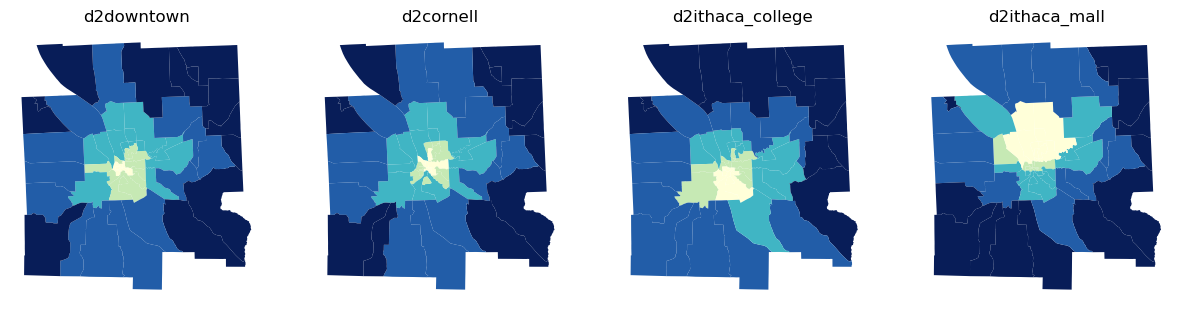

In [38]:
# Picking the variables that I want to visualize
plot_distance = ["d2downtown", "d2cornell", "d2ithaca_college", "d2ithaca_mall"]

# Building a visual summary of the data
f, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(plot_distance):
    ax = axs[i]
    # Plot the map
    blockgrps_acs.plot(column=col, ax=ax, scheme="Quantiles", linewidth=0.5, cmap="YlGnBu")
    ax.set_axis_off()
    ax.set_title(col)
plt.show()

### 3.5. Creating a spatial join between blockgrps_acs and ithaca_busstops

A spatial join between the census data and the Ithaca bus stop data to combines the demographic information of each block group with the corresponding bus stop locations.

Spatial join enables to create a new dataset that contains information from both datasets, such as the total population of each block group and the number of bus stops within each block group's catchment area. By combining these datasets, the relationship between demographic variables and public transportation usage can be explored. Matching each block group in the census data with the bus stops within its catchment area. Once the join is completed,the spatial regression analysis to examine the relationship between the dependent variable (such as number of bus stops) and the independent variables (such as total population, median household income, and distance to major locations) can be performed while accounting for spatial dependence.

In [18]:
# Renaming some column names for convenience
blockgrps_acs = blockgrps_acs.rename(columns = {'BLKGRPCE': 'blckgrps_id'})

blckgrps_busstops = gpd.tools.sjoin(ithaca_busstops, blockgrps_acs, how='right')

# Dropping all unnecessary columns
blckgrps_busstops = blckgrps_busstops.drop(columns = ['network', 'public_transport', 'highway','name',
                                                     'operator', 'operator',
                                                     'GISJOIN', 'STATEFP', 'COUNTYFP',
                                                     'TRACTCE', 'INTPTLAT', 'INTPTLON', 
                                                     'Shape_Leng', 'Shape_Area', 'centroids',
                                                     'pop_some_race', 'pop_hawaiian', 'pop_asian', 'pop_am_indian',
                                                     'pop_black', 'pop_takes_bus',
                                                      'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'index_left1'] )
# Renaming columns
blckgrps_busstops = blckgrps_busstops.rename(columns= {'index_left0': 'bus_stops'})

# Replacing Nans
blckgrps_busstops['median_hh_inc'] = blckgrps_busstops['median_hh_inc'].fillna('0.0')

#### 3.5.1. Creating mixed sample of blocks

Creating a mixed sample dataset of block groups with and without bus stops avoids the issue of selection bias, which occurs when the sample data used for the regression analysis is not representative of the population as a whole. If only block groups with bus stops to run the regression analysis are used, it may lead to overestimation the impact of the independent variables on the number of bus stops. This is because the sample data only includes block groups that have bus stops, and not those that do not.

By creating a mixed sample dataset of block, the impact of the independent variables on the number of bus stops can be estimated more accurately. The regression analysis will provide with insights into the factors that influence the location and number of bus stops, and can help inform decisions related to public transportation planning.

The number of bus stops has been considered as the dependent variable in this case because it is the variable that is being predicted or explained by the other independent variables. 
In this case, the aim is to understand how changes in variables such as total population, percentage minority, and distance to major locations affect the number of bus stops in a given block.

In [19]:
# Creating a sample of blocks with no bus stops 
no_busstops= blckgrps_busstops[blckgrps_busstops['bus_stops'] .isna()==True].sample(frac=.3)

# Creating a mixed sample of blocks with and without bus stops
mixed_block_sample = blckgrps_busstops[(blckgrps_busstops['GEOID'].isin(no_busstops['GEOID'].values)==False)]

# Converting bus_stops to a binary variable that takes 1 when bus_stops is node, otherwise 0.
mixed_block_sample['bus_stops'] = (mixed_block_sample['bus_stops'] == 'node').astype(int)

C:\Users\rimjh\.conda\envs\gds_py\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### 3.6. Number of Bus Stops in Different Blocks

The number of bus stops can be considered as the dependent variable in this case because it is the variable that is being predicted or explained by the other independent variables. 
In this case, the aim is to understand how changes in variables such as total population, percentage minority, and distance to major locations affect the number of bus stops in a given block.

In [20]:
# Creating a dataset of number of bus stops
n_busstops = mixed_block_sample.groupby('GEOID').sum()['bus_stops']

# Adding n_busstops to mixed_block_sample
mixed_block_sample = pd.merge(mixed_block_sample, n_busstops, on='GEOID', how='left')
mixed_block_sample = mixed_block_sample.rename(columns={'bus_stops_y':'n_busstops'})

C:\Users\rimjh\AppData\Local\Temp\ipykernel_4336\676813978.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_busstops = mixed_block_sample.groupby('GEOID').sum()['bus_stops']


In [41]:
# Inspecting mixed_block_sample
mixed_block_sample.head()

,bus_stops_x,blckgrps_id,GEOID,geometry,median_hh_inc,total_pop,pop_travels,perc_minority,perc_takes_bus,pop_density,d2downtown,d2cornell,d2ithaca_college,d2ithaca_mall,n_busstops
0,1,1,361090001001,"POLYGON ((-76.49218 42.44060, -76.49217 42.440...",41184.0,1132,748,0.14576,0.308824,0.004677,0.133938,1.519983,2.006018,5.135785,4
1,1,1,361090001001,"POLYGON ((-76.49218 42.44060, -76.49217 42.440...",41184.0,1132,748,0.14576,0.308824,0.004677,0.133938,1.519983,2.006018,5.135785,4
2,1,1,361090001001,"POLYGON ((-76.49218 42.44060, -76.49217 42.440...",41184.0,1132,748,0.14576,0.308824,0.004677,0.133938,1.519983,2.006018,5.135785,4
3,1,1,361090001001,"POLYGON ((-76.49218 42.44060, -76.49217 42.440...",41184.0,1132,748,0.14576,0.308824,0.004677,0.133938,1.519983,2.006018,5.135785,4
4,1,2,361090001002,"POLYGON ((-76.49440 42.44144, -76.49573 42.441...",33039.0,627,372,0.15311,0.341398,0.002336,0.371341,1.836546,2.066364,5.109995,4


## 4. Spatial Regression to Predict number of Bus Stops

### 4.1 Ordinary Least Squares (OLS) Regression with Spatial Lag Model

OLS regression is useful in this scenario because it allows identification of the linear relationship between the dependent and independent variables and estimate the strength of the relationship. Additionally, the spatial lag model in combination with OLS regression will help you take into account the spatial dependencies between observations, which can be important in spatial analysis.

#### 4.1(a) Initializing X and y

The dataset contains several **independent variables** such as **median household income, total population, percentage of minority population, percentage of people who take the bus, population density, distance from the downtown area, distance from Cornell University, distance from the Ithaca Mall, distance from Ithaca College**, and the **dependent variable** is the **number of bus stops** in a given area. 

The **independent variables** have been compiled in a Pandas dataframe named **X**, along with the corresponding geometries. The **dependent variable**, the number of bus stops, has been compiled in another Pandas dataframe named **y**. The purpose of this dataset is to build a model to predict the number of bus stops in a given area based on the independent variables.

In [21]:
# Initialising X 
# Storing independent variables
feature_cols = ["median_hh_inc", "total_pop", "perc_minority", "pop_density", "pop_travels", "d2downtown", "d2cornell", "d2ithaca_mall", "d2ithaca_college"]

# Creating dataframe
X = mixed_block_sample[feature_cols].astype(float)

# Adding column geometry to X
X = gpd.GeoDataFrame(X, geometry = mixed_block_sample['geometry']).set_crs(epsg = 4326)

# Fill missing values with zero
X = X.fillna(0)

# Initialising y
y = mixed_block_sample['n_busstops']
y = y.fillna(0)

#### 4.1(b) Creating spatial weights matrix

Creating a spatial weights matrix using the k-nearest neighbors (KNN) approach can be useful for an OLS spatial lag model when predicting the number of new bus stops in a given area.

In an OLS spatial lag model, the dependent variable (in this case, the number of bus stops) is regressed on both the independent variables and a spatial lag of the dependent variable. The spatial lag variable takes into account the spatial autocorrelation of the dependent variable, i.e., the fact that the value of the dependent variable in a given area is likely to be related to the values of the dependent variable in nearby areas.

Using the KNN approach allows for the spatial weights to reflect the local spatial relationships between areas, rather than a global measure of spatial proximity. This can be useful in predicting the number of new bus stops, as it takes into account the fact that areas with similar characteristics (e.g., population density, etc.) may be more likely to have similar numbers of bus stops. By including this local spatial information, the OLS spatial lag model with KNN-based spatial weights can potentially improve the accuracy of the predictions.

In [22]:
# Creating a spatial weight matrix using
w_knn = weights.KNN.from_dataframe(X, k=4)
# Row-standardization
w_knn.transform = 'R'

C:\Users\rimjh\.conda\envs\gds_py\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


#### 4.1(c) Running Ordinary Least Squares (OLS) Regression with Spatial Lag Model

In [23]:
import warnings
warnings.filterwarnings("ignore")

from pysal.model import spreg

In [24]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y.values,
    # Independent variables
    X[feature_cols].values,
    #spatial weights
    w=w_knn,
    # Dependent variable name
    name_y='n_busstops',
    # Independent variable name
    name_x=feature_cols,
)

In [25]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  n_busstops                Number of Observations:         118
Mean dependent var  :      6.6525                Number of Variables   :          10
S.D. dependent var  :      6.9913                Degrees of Freedom    :         108
R-squared           :      0.6984
Adjusted R-squared  :      0.6733
Sum squared residual:    1724.535                F-statistic           :     27.7934
Sigma-square        :      15.968                Prob(F-statistic)     :   2.582e-24
S.E. of regression  :       3.996                Log likelihood        :    -325.674
Sigma-square ML     :      14.615                Akaike info criterion :     671.349
S.E of regression ML:      3.8229                Schwarz criterion     :     699.056

-----------------------------------------------------------------------------

#### 4.1(d) Interpretation of OLS Regression Summary

The regression analysis shows that the overall model is statistically significant (F-statistic = 27.7934) and can explain 69.84% of the variability in the dependent variable (R-squared = 0.6984). The adjusted R-squared value (0.6733) indicates that the model has a good fit, taking into account the number of variables included in the analysis.

The coefficient estimates for the independent variables reveal that the variables "perc_minority," "pop_density," "d2downtown," "d2ithaca_mall," and "d2ithaca_college" have a statistically significant relationship with the number of bus stops. Specifically, these variables have a positive relationship with the number of bus stops, while "d2downtown" has a negative relationship with the number of bus stops. In contrast, the variables "median_hh_inc," "total_pop," and "pop_travels" do not have a statistically significant relationship with the number of bus stops.

A detailed interpretation of the co-efficients are as following:

1. *CONSTANT*: This represents the intercept term, which is the value of the dependent variable (n_busstops) when all independent variables are zero. In this case, the intercept is -12.696, which means that when all other variables are zero, the model predicts that there are about 12 fewer bus stops than the mean value of the dependent variable.
2. *median_hh_inc*: This variable represents the median household income in the area. The coefficient of -0.0000152 suggests that as the median household income increases by one unit, the number of bus stops decreases by 0.0000152 units, but this effect is not statistically significant as the p-value is higher than 0.05.
3. *total_pop*: This variable represents the total population of the area. The coefficient of -0.0002046 suggests that as the total population increases by one unit, the number of bus stops decreases by 0.0002046 units, but this effect is not statistically significant as the p-value is higher than 0.05.
4. *perc_minority*: This variable represents the percentage of the population that identifies as a minority. The coefficient of 36.637 suggests that as the percentage of the population that identifies as a minority increases by one unit, the number of bus stops increases by 36.637 units.
5. *pop_density*: This variable represents the population density of the area. The coefficient of -819.7667 suggests that as the population density increases by one unit, the number of bus stops decreases by 819.7667 units, and this effect is statistically significant as the p-value is less than 0.05.
6. *pop_travels*: This variable represents the number of people who travel to work by public transportation. The coefficient of 0.0055597 suggests that as the number of people who travel to work by public transportation increases by one unit, the number of bus stops increases by 0.0055597 units, but this effect is not statistically significant as the p-value is higher than 0.05.
7. *d2downtown*: This variable represents the distance from the area to downtown. The coefficient of -3.8807 suggests that as the distance from the area to downtown increases by one unit, the number of bus stops decreases by 3.8807 units, and this effect is statistically significant as the p-value is less than 0.05.
8. *d2cornell*: This variable represents the distance from the area to Cornell University. The coefficient of -0.1873 suggests that as the distance from the area to Cornell University increases by one unit, the number of bus stops decreases by 0.1873 units, but this effect is not statistically significant as the p-value is higher than 0.05.
9. *d2ithaca_mall*: This variable represents the distance from the area to the Ithaca Mall. The coefficient of 1.7252 suggests that as the distance from the area to the Ithaca Mall increases by one unit, the number of bus stops increases by 1.7252 units, and this effect is statistically significant as the p-value is less than 0.05.
10. *d2ithaca_college*: This variable represents the distance from the area to Ithaca College. The coefficient of 2.7967 suggests that as the distance from the area to Ithaca College increases by one unit, the number of bus stops increases by 2.7967 units, and this effect is statistically significant as the p-value is less than 0.05.

The results of this OLS regression analysis may not accurately reflect the real-world relationships between the variables. For instance, an increase in population in a block could be an indicator to increase the number of bus stops in the block, but the summary does not suggest a statistically significant relationship between the two variables. This discrepancy is an indicator this OLS model can further be revised to produce better results.

### 4.2 Verfication through Residuals

The residuals of the OLS model represent the difference between the actual number of bus stops and the predicted number of bus stops by the model. By examining the spatial pattern of the residuals, it can be assessed whether the OLS model captures all the spatial factors that affect the number of bus stops or not.

If the residuals show a spatial pattern, it suggests that there are still some spatial factors that were not included in the model and that affect the number of bus stops. This could be due to spatial autocorrelation, where the value of a variable in one location is related to the values of the same variable in neighboring locations. 

Therefore, the spatial characteristics of the residuals can provide valuable information on whether we need to include additional spatial variables in the model or use a different model altogether. This information can help in further improving the model to better represent the reality.

In [27]:
# Create column with residual values from m1
X["residual"] = m1.u

# Calculating global Moran's I
moran_wknn = Moran(X["residual"], w_knn)

# Inspecting Moran's I value
moran_wknn.I

0.6262774565529182

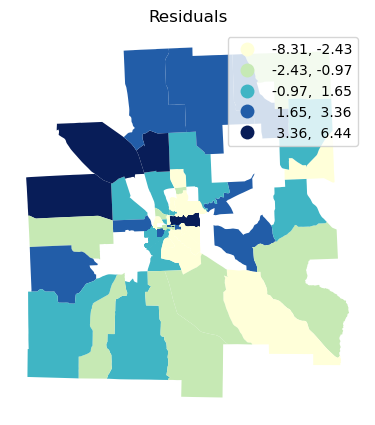

In [30]:
# Plotting Residuals
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(5, 5))
# Plot unique values choropleth
# including a legend and with no boundary lines
X.plot(column="residual", scheme="quantiles", k=5, ax=ax, cmap="YlGnBu", legend=True)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Residuals')
# Display the map
plt.show()

The Moran's I value for residuals is 0.626, which is a positive value close to 1. This suggests that there is significant spatial clustering in the residuals, indicating the presence of spatial dependence in the data that is not accounted for in the regression model. This means that the residuals are not randomly distributed in space, but rather exhibit spatial patterns that are related to the location of the observations.

### 4.3 Spatial Lag Regression Model

A spatial lag model would be appropriate because it considers the spatial relationships among bus stops and their surroundings. It can help capture the effect of unobserved factors that may be spatially correlated, such as urbanization or population density, on the dependent variable. By incorporating the spatial dependence structure of the data, a spatial lag model can provide more accurate estimates of the regression coefficients and standard errors than a traditional OLS model, which assumes that observations are independent.

In [34]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m2 = spreg.GM_Lag(
    # Dependent variable
    y.values,
    # Independent variables
    X[feature_cols].values,
    #spatial weights
    w=w_knn,
    # Dependent variable name
    name_y='n_busstops',
    # Independent variable name
    name_x=feature_cols,
)

In [35]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  n_busstops                Number of Observations:         118
Mean dependent var  :      6.6525                Number of Variables   :          11
S.D. dependent var  :      6.9913                Degrees of Freedom    :         107
Pseudo R-squared    :      0.9644
Spatial Pseudo R-squared:  0.2374

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -7.7454708       1.2409997      -6.2413158       0.0000000
       median_hh_inc       0.0000162       0.0000080       2.0177866       0.0436135
           total_pop       0.0003011       0.0003388       

#### 4.3(a) Interpretation of Spatial Lag Regression Summary

The pseudo R-squared is 0.9644, which suggests that the model explains a high proportion of the variance in the dependent variable. The spatial pseudo R-squared is 0.2374, which indicates that the spatially lagged dependent variable is a good predictor of the dependent variable.

The analysis suggests that the variables "median_hh_inc", "perc_minority", "d2downtown", "d2ithaca_mall", "d2ithaca_college", and "W_n_busstops" have statistically significant coefficients, as their p-values are below 0.05. The variables "total_pop", "pop_density", "pop_travels", and "d2cornell" are not statistically significant, as their p-values are above 0.05.

A detailed interpretation of the co-efficients are as following:

1. *CONSTANT*: This is the intercept or the value of n_busstops when all the other variables are zero. The coefficient value of -7.745 suggests that if all the other variables are held constant at zero, there would still be a negative value for n_busstops. However, since this is a regression model, it's unlikely that all the other variables would be zero.
2. *median_hh_inc*: The coefficient value of 0.0000162 suggests that a one-unit increase in median_hh_inc is associated with a 0.0000162 unit increase in n_busstops, holding all other variables constant. Since the p-value is less than 0.05, we can say that this relationship is statistically significant.
3. *total_pop*: The coefficient value of 0.0003011 suggests that a one-unit increase in total_pop is associated with a 0.0003011 unit increase in n_busstops, holding all other variables constant. However, the p-value is greater than 0.05, so this relationship is not statistically significant.
4. *perc_minority*: The coefficient value of 8.4397413 suggests that a one-unit increase in perc_minority is associated with an 8.4397413 unit increase in n_busstops, holding all other variables constant. Since the p-value is less than 0.05, we can say that this relationship is statistically significant.
5. *pop_density*: The coefficient value of -140.9193058 suggests that a one-unit increase in pop_density is associated with a -140.9193058 unit decrease in n_busstops, holding all other variables constant. Since the coefficient is negative, this suggests that areas with higher population densities have fewer bus stops. This relationship is also statistically significant because the p-value is less than 0.05.
6. *pop_travels*: The coefficient value of -0.0001473 suggests that a one-unit increase in pop_travels is associated with a -0.0001473 unit decrease in n_busstops, holding all other variables constant. However, the p-value is greater than 0.05, so this relationship is not statistically significant.
7. *d2downtown*: The coefficient value of -2.4345408 suggests that a one-unit increase in d2downtown is associated with a -2.4345408 unit decrease in n_busstops, holding all other variables constant. This suggests that areas further from downtown have fewer bus stops. This relationship is also statistically significant because the p-value is less than 0.05.
8. *d2cornell*: The coefficient value of 0.4198023 suggests that a one-unit increase in d2cornell is associated with a 0.4198023 unit increase in n_busstops, holding all other variables constant. However, the p-value is greater than 0.05, so this relationship is not statistically significant.
9. *d2ithaca_mall*: The coefficient value of 0.6225215 suggests that a one-unit increase in d2ithaca_mall is associated with a 0.6225215 unit increase in n_busstops, holding all other variables constant. Since the p-value is less than 0.05, we can say that this relationship is statistically significant.
10. *d2ithaca_college*: The coefficient of d2ithaca_college is 1.7295241, which means that for a one-unit increase in the distance between a census block and Ithaca College (d2ithaca_college), the expected value of the dependent variable (n_busstops) increases by 1.7295241, all other variables being held constant.
11. *W_n_busstops*: It represents the average number of bus stops in the surrounding areas of a location. The coefficient of "w_n_busstops" in the output indicates that a one-unit increase in the average number of bus stops in the neighboring areas leads to a 0.9634 unit increase in the number of bus stops in the current location, holding other variables constant. This coefficient indicates a positive spatial spillover effect, where the number of bus stops in the surrounding areas has a positive impact on the number of bus stops in a given location. This suggests that the provision of public transportation facilities in one area can have a positive impact on the provision of similar facilities in the neighboring areas.


To determine whether the spatial lag model improves the performance of OLS in this case, the goodness of fit measures of both models can be compared. The pseudo R-squared values can give the indication of the goodness of fit. 

The OLS model has a pseudo R-squared value of 0.9644, which is a very high value indicating that the model explains a large proportion of the variation in the dependent variable. The spatial lag model has a higher spatial pseudo R-squared value of 0.2374, which indicates that this model has a better goodness of fit than the OLS model. This suggests that the spatial lag model improves the performance of OLS in this case.

## 5. Conclusion

In conclusion, this project aimed to enhance the design of a cohesive and inclusive public transportation system for Ithaca, New York by emphasizing the significance of data representation. Through the collection of bus stops data, census data at the block group level, and distances to key locations, a regression model to predict the placement of new bus stops was developed. The results underscored the importance of population density, proximity to important locations, and the percentage of minority residents in determining the number of bus stops in a given area. However, median household income and total population were not found to be influential predictors.

The findings also shed light on potential disparities in the spatial distribution of bus stops, indicating that certain communities may be underserved and encountering barriers in accessing opportunities and services due to limited transportation options. By employing data-driven approaches like the one presented here, policymakers can cultivate more inclusive public transportation systems that address the diverse needs of all residents. Furthermore, the utilization of a spatial lag regression model emerged as crucial to account for possible spatial autocorrelation in the data, mitigating the risk of omitted variable bias and obtaining more precise estimates of the regression coefficients.

This project holds valuable implications for policymakers and transportation planners, providing actionable insights to enhance urban public transportation systems. By integrating data-driven approaches and embracing inclusive data representation, cities like Ithaca can forge equitable and efficient transportation systems that empower and benefit all residents.